# Code


# Imports

In [11]:
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
from typing import Tuple
from typing import Optional, Tuple
import matplotlib.pyplot as plt

# User Configuration

In [12]:
SAVE_CSV = True  # Save figures
SAVE_FIG = True  # Save figures

AD_FILE = "ad_bootstrap_1000_results.csv"
CV_FILE = "cramersV_bootstrap_1000_results.csv"
KS_FILE = "ks_bootstrap_1000_results.csv"

OUTPUT_DIR_CSV = Path("results")
OUTPUT_DIR_CSV.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR_FIG = Path("figures")
OUTPUT_DIR_FIG.mkdir(parents=True, exist_ok=True)

N_BOOTSTRAP = 1000 

sns.set_theme(
    style="white",
    context="paper",
    palette="colorblind",
    rc={
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
        "font.size": 7,
        "axes.titlesize": 7,
        "axes.labelsize": 7,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "legend.fontsize": 7
    }
)

# Allgemeine Datenaufbereitung
## Daten laden

In [13]:
ad = pd.read_csv(OUTPUT_DIR_CSV / AD_FILE, decimal=",", sep=";", encoding="utf-8")
cv = pd.read_csv(OUTPUT_DIR_CSV / CV_FILE, decimal=",", sep=";", encoding="utf-8")
ks = pd.read_csv(OUTPUT_DIR_CSV / KS_FILE, decimal=",", sep=";", encoding="utf-8")

## Ins Long-Format

In [14]:
ad_wide = ad.copy()
ad_wide['run_id'] = ad_wide.index

ad_long = ad_wide.melt(
    id_vars='run_id',
    var_name='feature',
    value_name='ad_stat'
)

# Extract the AD values from the feature names
ad_long['feature'] = ad_long['feature'].str.replace('_stat', '', regex=False)
ad_long['stat_type'] = "AD"
ad_long = ad_long.rename(columns={"ad_stat": "value"})

cv_df = cv.filter(like='_V')
cv_wide = cv_df.copy()
cv_wide['run_id'] = cv_df.index

cv_long = cv_wide.melt(
    id_vars='run_id',
    var_name='feature',
    value_name='cv_stat'
)

# Extract the Cramér's V values from the feature names
cv_long['feature'] = cv_long['feature'].str.replace('_V', '', regex=False)
cv_long['stat_type'] = "CV"
cv_long = cv_long.rename(columns={"cv_stat": "value"})

ks_wide = ks.copy()
ks_wide['run_id'] = ks_wide.index

ks_long = ks_wide.melt(
    id_vars='run_id',
    var_name='feature',
    value_name='ks_stat'
)

# Extract the KS and TVD values from the feature names
ks_long["stat_type"] = ks_long["feature"].str.extract(r'_(TVD|KS)$')[0]
ks_long["feature"] = ks_long["feature"].str.replace(r'_(TVD|KS)$', '', regex=True)
ks_long = ks_long.rename(columns={"ks_stat": "value"})
tvd_long = ks_long[ks_long["stat_type"] == "TVD"].copy()
ks_long = ks_long[ks_long["stat_type"] != "TVD"].copy()

# CI Stability Plots
## Utility Function


In [15]:
def prepare_ci_df(
    values,
    bootstrap_sizes: list[int] | None = None,
    max_size: int | None = None,
    num_sizes: int = 10
) -> pd.DataFrame:
    """
    Berechnet für verschiedene Bootstrap-Größen das Mittel und Konfidenzintervalle (2.5% & 97.5%).

    Parameters
    ----------
    values : array-like
        1D-Array oder pd.Series mit den zu bootstrappenden Werten.
    bootstrap_sizes : list[int], optional
        Explizite Liste von Bootstrap-Größen. Wenn None, wird log-spaced erzeugt.
    max_size : int, optional
        Maximaler Bootstrap-Wert für die automatische Erzeugung (Default = len(values)).
    num_sizes : int
        Anzahl der Punkte bei automatischer Erzeugung via geomspace.

    Returns
    -------
    pd.DataFrame mit Spalten
      - n_bootstrap
      - stat_mean
      - stat_2_5
      - stat_97_5
    """
    # Rohdaten als numpy-Array
    arr = np.asarray(values, dtype=float)
    N = len(arr)

    # Bootstrap-Größen festlegen
    if bootstrap_sizes is None:
        max_n = max_size or N
        bootstrap_sizes = np.unique(
            np.geomspace(10, max_n, num=num_sizes, dtype=int)
        ).tolist()

    # Cumsum für schnelle Mittelwert‐Berechnung
    csum = arr.cumsum()

    results = []
    for n in bootstrap_sizes:
        if n <= 0 or n > N:
            continue
        slice_ = arr[:n]
        mean = csum[n-1] / n
        p2_5, p97_5 = np.percentile(slice_, [2.5, 97.5])
        results.append({
            'n_bootstrap': n,
            'stat_mean':    mean,
            'stat_2_5':     p2_5,
            'stat_97_5':    p97_5
        })

    return pd.DataFrame(results)

In [81]:
def plot_ci_stability(
    df: pd.DataFrame,
    ax: Optional[plt.Axes] = None,
    figsize: Tuple[int, int] = (12, 6),
    log_x: bool = True
) -> Tuple[plt.Figure, plt.Axes]:
    """
    Zeichnet n_bootstrap vs. stat_mean + CI-Fill.
    Wenn `ax` übergeben wird, malt in dieses Subplot,
    sonst erzeugt es ein neues Figure/Axes-Paar.
    """
    # 1) Figure/Axes ggf. selbst anlegen
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure

    # 2) Lineplot
    sns.lineplot(
        data=df,
        x='n_bootstrap',
        y='stat_mean',
        marker='o',
        ax=ax,
        label='Mean',
    )

    # 3) Confidence-Interval-Fill
    ax.fill_between(
        df['n_bootstrap'],
        df['stat_2_5'],
        df['stat_97_5'],
        alpha=0.3,
        label='95% CI'
    )

    # 4) Styling
    ax.set_xscale('log')
    ax.set_xlabel('Number of Bootstrap Iterations')
    ax.set_ylabel('Test Statistic Value')
    ax.set_title('Stability of the 95% CI')
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(loc='upper right')

    return fig, ax, []

## Daten-Aufbereitung
### Daten laden

In [17]:
cv_long.head()

,run_id,feature,value,stat_type
0,0,icu_admission_24h,0.037280,CV
1,1,icu_admission_24h,0.051124,CV
2,2,icu_admission_24h,0.035873,CV
3,3,icu_admission_24h,0.044621,CV
4,4,icu_admission_24h,0.042861,CV


In [18]:
bootstrap_sizes = np.unique(np.geomspace(10, N_BOOTSTRAP, num=10, dtype=int)).tolist()


df_ks = prepare_ci_df(ks_long[ks_long["feature"] == "age"]["value"], bootstrap_sizes)
df_ks["stat_type"] = "KS"

df_ad = prepare_ci_df(ad_long[ad_long["feature"] == "age"]["value"], bootstrap_sizes)
df_ad["stat_type"] = "AD"

df_cv = prepare_ci_df(cv_long[cv_long["feature"] == "icu_admission_24h"]["value"], bootstrap_sizes)
df_cv["stat_type"] = "CV"

df_tvd = prepare_ci_df(tvd_long[tvd_long["feature"] == "icu_admission_24h"]["value"], bootstrap_sizes)
df_tvd["stat_type"] = "TVD"

In [19]:
print(df_tvd)

   n_bootstrap  stat_mean  stat_2_5  stat_97_5 stat_type
0           10   0.027680  0.016710   0.033620       TVD
1           16   0.028850  0.017850   0.036875       TVD
2           27   0.028259  0.014020   0.035740       TVD
3           46   0.028617  0.015750   0.038275       TVD
4           77   0.028997  0.015000   0.041220       TVD
5          129   0.029420  0.015160   0.041000       TVD
6          215   0.029276  0.015940   0.040920       TVD
7          359   0.029379  0.015390   0.042010       TVD
8          599   0.029574  0.016580   0.042800       TVD
9         1000   0.029591  0.016795   0.042405       TVD


In [20]:
df_ci = pd.concat([df_ks, df_ad, df_cv, df_tvd], ignore_index=True)
# combined.loc[combined['feature'].str.endswith('_TVD'), 'stat'] = 'TVD'
# combined['feature'] = combined['feature'].str.replace('_TVD', '', regex=False).str.replace('_KS', '', regex=False)
print(df_ci)

    n_bootstrap  stat_mean   stat_2_5  stat_97_5 stat_type
0            10   0.071360   0.055590   0.084420        KS
1            16   0.071125   0.055575   0.084300        KS
2            27   0.069259   0.052520   0.084080        KS
3            46   0.069483   0.052100   0.084500        KS
4            77   0.071130   0.052720   0.085480        KS
5           129   0.070847   0.053600   0.087720        KS
6           215   0.071375   0.053600   0.089440        KS
7           359   0.071584   0.053790   0.088020        KS
8           599   0.071355   0.053800   0.088810        KS
9          1000   0.071466   0.053800   0.088405        KS
10           10  21.334826  11.091667  28.059260        AD
11           16  21.249963   9.609420  31.124446        AD
12           27  21.082655   9.897703  31.771277        AD
13           46  20.974333   9.772227  32.710126        AD
14           77  20.614005  10.208337  33.061959        AD
15          129  20.021817   9.814431  32.386826        

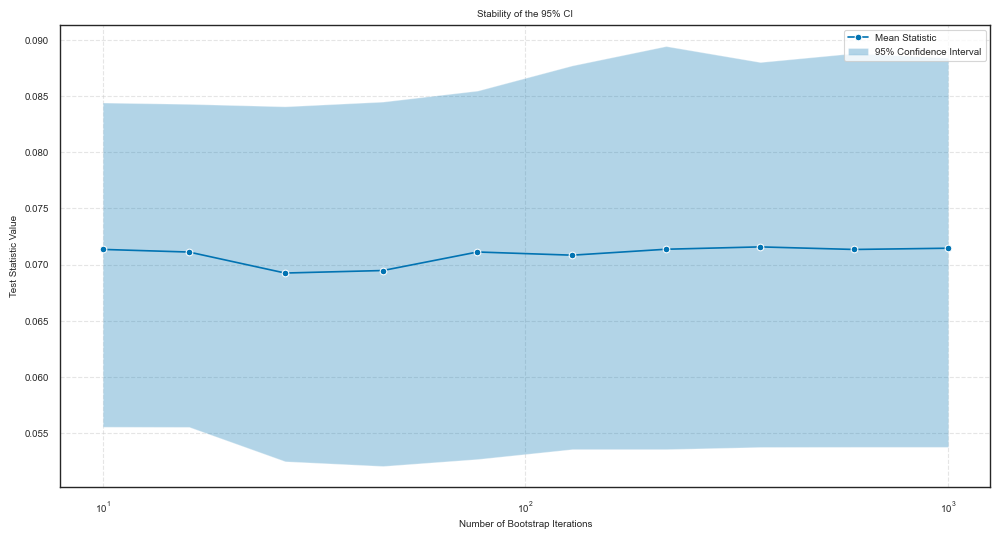

In [21]:
fig, ax = plot_ci_stability(df_ci[df_ci['stat_type'] == "KS"], figsize=(12, 6))
plt.show()
plt.close(fig)

# Test Statistic Plots
## Utility Function

In [22]:
def calc_featurewise_ci_fwer(
    df_results: pd.DataFrame,
    delta: float = 0.05,          # Äquivalenzgrenze
    alpha_global: float = 0.05,   # gewünschtes family-wise α
    title: str = "ks_stat"
):
    m = df_results.shape[1]                 # Zahl der parallelen Features
    alpha_local = alpha_global / m          # Bonferroni-Teilung
    lo_p  = 100 * (alpha_local / 2)         # z. B. 0.125 %
    hi_p  = 100 * (1 - alpha_local / 2)     # z. B. 99.875 %

    # --------------------------------------------------------
    # 1) simultane CIs + Mittelwerte berechnen
    # --------------------------------------------------------
    summary = []
    for feat, vals in df_results.items():
        lower = np.percentile(vals, lo_p)
        upper = np.percentile(vals, hi_p)
        mean_ = vals.mean()
        summary.append(
            dict(feature=feat,
                 mean_stat=mean_,
                 ci_lower=lower,
                 ci_upper=upper,
                 equiv = upper < delta)     # Entscheidung
        )
    df_sum = pd.DataFrame(summary)

    # Fehlerbalken für Matplotlib
    df_sum["err_low"]  = df_sum["mean_stat"] - df_sum["ci_lower"]
    df_sum["err_high"] = df_sum["ci_upper"] - df_sum["mean_stat"]
    df_sum["data"] = title
    return df_sum

In [105]:
def plot_featurewise_ci_fwer(
    ax: plt.Axes,
    df: pd.DataFrame,
    delta: float = 0.05,          # Equivalence threshold
    alpha_global: float = 0.05,   # Desired family-wise α
    title: str = "Test Statistic",
    leg_pos: str = "upper right",
):

    # Color assignment: equivalent = blue, not equivalent = orange
    palette_cb = sns.color_palette("colorblind", 2)
    colors = df["equiv"].map({True: palette_cb[0], False: palette_cb[1]})

    # Points
    ax.scatter(x=df.index,
               y=df["mean_stat"],
               c=colors,
               s=20,
               zorder=3)

    # Error bars (asymmetric)
    for idx, row in df.iterrows():
        ax.errorbar(x=idx,
                    y=row["mean_stat"],
                    yerr=[[row["err_low"]], [row["err_high"]]],
                    fmt="none",
                    ecolor=colors.iloc[idx],
                    elinewidth=1.5,
                    capsize=4,
                    zorder=2)

    # Threshold δ
    ax.axhline(delta, color="grey", ls="--", lw=1, label=f"δ = {delta}", zorder=1)

    # maxlen = 8
    # xtick_labels = [str(f)[:maxlen] + '…' if len(str(f)) > maxlen else str(f) for f in df["feature"]]
    # Axis styling
    ax.set_xticks(df.index)
    ax.set_xticklabels(df["feature"], rotation=65, ha="right", fontsize=6)
    # ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=6)
    # ax.set_ylabel(title)
    # ax.set_xlabel("Feature")
    ax.set_title(f"{title}: simultaneous {(1-alpha_global):.0%} CIs (Bonferroni-corrected)")
    ax.grid(axis="y", ls="--", alpha=0.5)

    # Legend
    from matplotlib.patches import Patch
    handles = [Patch(color=palette_cb[0], label="Equiv. (CI < δ)"),
               Patch(color=palette_cb[1], label="Not equiv."),
               ax.lines[-1]]        # δ line
    # ax.legend(handles=handles, loc=leg_pos)
    # ax.legend(handles=handles, loc="upper left", fontsize=6)
    
    plt.tight_layout()

    return ax, df, handles            # df_sum contains the full table


## Daten-Aufbereitung

In [46]:
ks_sum = calc_featurewise_ci_fwer(
    df_results   = ks_long.pivot(index="run_id", columns="feature", values="value"),
    delta        = 0.05,
    alpha_global = 0.05,
    title = "ks_stat"
)
ks_sum.to_csv(OUTPUT_DIR_CSV / f"ks_20250517.csv", sep=";", decimal=",", index=False)

cv_sum = calc_featurewise_ci_fwer(
    df_results   = cv_long.pivot(index="run_id", columns="feature", values="value"),
    delta        = 0.05,
    alpha_global = 0.05,
    title= "cv_stat"
)
cv_sum.to_csv(OUTPUT_DIR_CSV / f"cv_20250517.csv", sep=";", decimal=",", index=False)

ad_sum = calc_featurewise_ci_fwer(
    df_results   = ad_long.pivot(index="run_id", columns="feature", values="value"),
    delta        = 25,
    alpha_global = 0.05,
    title= "ad_stat"
)
ad_sum.to_csv(OUTPUT_DIR_CSV / f"ad_20250517.csv", sep=";", decimal=",", index=False)

tvd_sum = calc_featurewise_ci_fwer(
    df_results   = tvd_long.pivot(index="run_id", columns="feature", values="value"),
    delta        = 0.05,
    alpha_global = 0.05,
    title= "tvd_stat"
)
tvd_sum.to_csv(OUTPUT_DIR_CSV / f"tvd_20250517.csv", sep=";", decimal=",", index=False)

## Daten kombinieren

In [47]:
def load_summary(df: pd.DataFrame, stat_label: str) -> pd.DataFrame:
    """
    Lädt eine Bootstrap-Zusammenfassung und bereitet sie auf.
    Erwartet CSV ohne Header, Semikolon-separiert, mit Zeile 1 als Header.
    """
    # Überspringe die erste Zeile (evtl. doppelter Header) und lese rest
    df.columns = ["feature", "mean_stat", "ci_lower", "ci_upper", "equiv", "err_low", "err_high", "stat_type"]
    # Numerische Spalten umwandeln
    for col in ["mean_stat", "ci_lower", "ci_upper", "err_low", "err_high"]:
        df[col] = df[col].astype(str).str.replace(",", ".").str.replace(" ", "").astype(float)
    df["equiv"] = df["equiv"].astype(str).str.lower() == "true"
    df["stat"] = stat_label
    return df

# Lade alle drei Statistiken
ks_df = load_summary(ks_sum, "KS")
cv_df = load_summary(cv_sum, "CV")
ad_df = load_summary(ad_sum, "AD")
tvd_df = load_summary(tvd_sum, "TVD")

combined = pd.concat([ks_df, cv_df, ad_df, tvd_df], ignore_index=True)
# combined.loc[combined['feature'].str.endswith('_TVD'), 'stat'] = 'TVD'
# combined['feature'] = combined['feature'].str.replace('_TVD', '', regex=False).str.replace('_KS', '', regex=False)
print(combined)

                feature   mean_stat    ci_lower    ci_upper  equiv    err_low  \
0                   age    0.071466    0.048741    0.093000  False   0.022725   
1          diastolic_bp    0.071127    0.046368    0.093805  False   0.024760   
2            heart_rate    0.107718    0.092514    0.125146  False   0.015204   
3     oxygen_saturation    0.143459    0.119709    0.168486  False   0.023751   
4      respiratory_rate    0.059655    0.044541    0.074459  False   0.015115   
5           systolic_bp    0.076125    0.052141    0.102605  False   0.023985   
6           temperature    0.092924    0.066595    0.116259  False   0.026329   
7       chief_complaint    0.015223    0.014063    0.016356   True   0.001161   
8   consciousness_level    0.056400    0.042082    0.068926  False   0.014318   
9             ethnicity    0.041710    0.029398    0.055754  False   0.012312   
10               gender    0.075118    0.045928    0.099627  False   0.029190   
11            icd_block    0

# Combine

In [48]:
ks_isolated = combined[combined["stat"] == "KS"].reset_index(drop=True)
tvd_isolated = combined[combined["stat"] == "TVD"].reset_index(drop=True)
cv_isolated = combined[combined["stat"] == "CV"].reset_index(drop=True)
ad_isolated = combined[combined["stat"] == "AD"].reset_index(drop=True)

data_list = [ks_isolated, ad_isolated, tvd_isolated, cv_isolated]
titles = ["Kolmogorov-Smirnov", "Anderson-Darling", "Total Variation Distance", "Cramér's V"]
deltas = [0.05, 25, 0.05, 0.05]
alphas = [0.05, 0.05, 0.05, 0.05]

In [49]:
data_list2 = [
    df_ci[df_ci['stat_type'] == "KS"],
    df_ci[df_ci['stat_type'] == "AD"],
    df_ci[df_ci['stat_type'] == "TVD"],
    df_ci[df_ci['stat_type'] == "CV"]
    
]


In [41]:
df_ci[df_ci['stat_type'] == "KS"]

,n_bootstrap,stat_mean,stat_2_5,stat_97_5,stat_type
0,10,0.071360,0.055590,0.084420,KS
1,16,0.071125,0.055575,0.084300,KS
2,27,0.069259,0.052520,0.084080,KS
3,46,0.069483,0.052100,0.084500,KS
4,77,0.071130,0.052720,0.085480,KS
5,129,0.070847,0.053600,0.087720,KS
6,215,0.071375,0.053600,0.089440,KS
7,359,0.071584,0.053790,0.088020,KS
8,599,0.071355,0.053800,0.088810,KS
9,1000,0.071466,0.053800,0.088405,KS


# asdasd

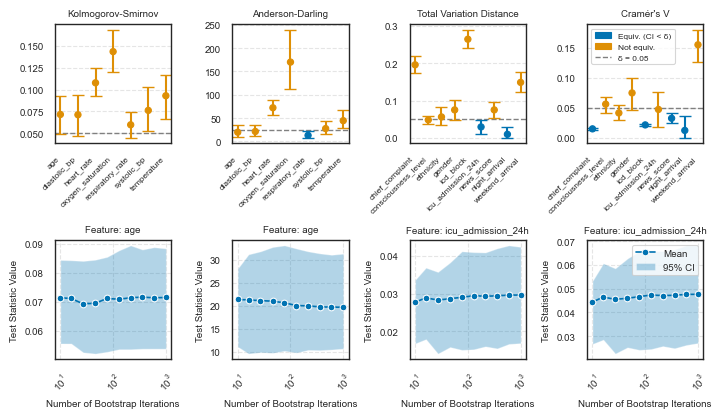

In [107]:
final_df = []
for i in range(4):
    final_df.append({
        'df': data_list[i],
        'plot_fn': plot_featurewise_ci_fwer,
        'title': titles[i],
        'plot_kwargs': {
            'delta': deltas[i],
            'alpha_global': alphas[i],
        }
    })

for i in range(4):
    feature = "age" if titles[i] in ("Kolmogorov-Smirnov", "Anderson-Darling") else "icu_admission_24h"
    final_df.append({
        'df': data_list2[i],
        'plot_fn': plot_ci_stability,
        # 'title': f"{titles[i]} (Feature: {feature})",
        'title': f"Feature: {feature}",
        'plot_kwargs': {  },
    })

fig, axs = plt.subplots(2, 4, figsize=(7.2, 4.2), sharex=False)
axs_flat = axs.flatten()

# 7) Loop über Spezifikationen
for idx, (ax, spec) in enumerate(zip(axs_flat, final_df)):
    out_ax, out_df, handles = spec['plot_fn'](
        ax=ax, 
        df=spec['df'],
        **spec['plot_kwargs']
    )
    ax.set_title(spec['title'])
    ax.tick_params(axis='x', rotation=45)

    if idx in [3, 7]:
        if handles:
            ax.legend(handles=handles, loc='upper left', fontsize=6)
        # handles, labels = ax.get_legend_handles_labels()
        # if handles:
        #     # ax.legend(handles, labels, loc='upper left')
        #     ax.legend(handles=handles, loc='upper left', fontsize=6)
    else:
        # Legende ggf. entfernen, falls Plotfunktion eine setzt
        ax.legend_.remove() if ax.get_legend() else None

plt.tight_layout()

# if SAVE_FIG:
#     fig.savefig(OUTPUT_DIR_FIG / f"hypothesis_tests_combined.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.show()

In [38]:
print(deltas[1])

25


In [ ]:
# Annahme: data_list, data_list2, deltas, alphas und labels sind definiert

fig, axs = plt.subplots(2, 4, figsize=(7.2, 7.2))

for idx, label in enumerate(labels):
    # obere Reihe: Featurewise FWER
    ax_fwer = axs[0, idx]
    plot_featurewise_ci_fwer(
        ax=ax_fwer,
        df_sum=data_list[idx],
        delta=deltas[idx],
        alpha_global=alphas[idx],
        title=label
    )

    # untere Reihe: CI-Stability
    ax_ci = axs[1, idx]
    stat_vals = data_list2[idx]["value"].to_numpy()          # Werte als Array
    feature = data_list2[idx]["feature"].iloc[0]             # "age"
    plot_ci_stability_long(
        ax=ax_ci,
        stat_vals=stat_vals,
        feature_label=f"{feature}_{label}",
        bootstrap_sizes=bootstrap_sizes
    )

plt.tight_layout()


# --- ALte Logik
## KS

In [ ]:
ks_isolated = combined[combined["stat"] == "KS"].reset_index(drop=True)
fig, ax, tbl = plot_featurewise_ci_fwer(
    df_sum       = ks_isolated,
    delta        = 0.05,
    alpha_global = 0.05,
    title        = "KS_statistic",
    figsize      = (1.8, 2)
)

## TVD

In [ ]:
tvd_isolated = combined[combined["stat"] == "TVD"].reset_index(drop=True)
fig, ax, tbl = plot_featurewise_ci_fwer(
    df_sum       = tvd_isolated,
    delta        = 0.05,
    alpha_global = 0.05,
    title        = "TVD_statistic",
    figsize      = (1.8, 2)
)

## CV

In [ ]:
cv_isolated = combined[combined["stat"] == "CV"].reset_index(drop=True)
fig, ax, tbl = plot_featurewise_ci_fwer(
    df_sum       = cv_isolated,
    delta        = 0.05,
    alpha_global = 0.05,
    title        = "CV statistic",
    figsize      = (4, 4.5),
    leg_pos = "upper left"
)

## AD

In [ ]:
ad_isolated = combined[combined["stat"] == "AD"].reset_index(drop=True)
fig, ax, tbl = plot_featurewise_ci_fwer(
    df_sum       = ad_isolated,
    delta        = 25,
    alpha_global = 0.05,
    title        = "AD_statistic",
    figsize      = (3.5, 4)
)